# Finding the possible symmetries for the regularized shapes

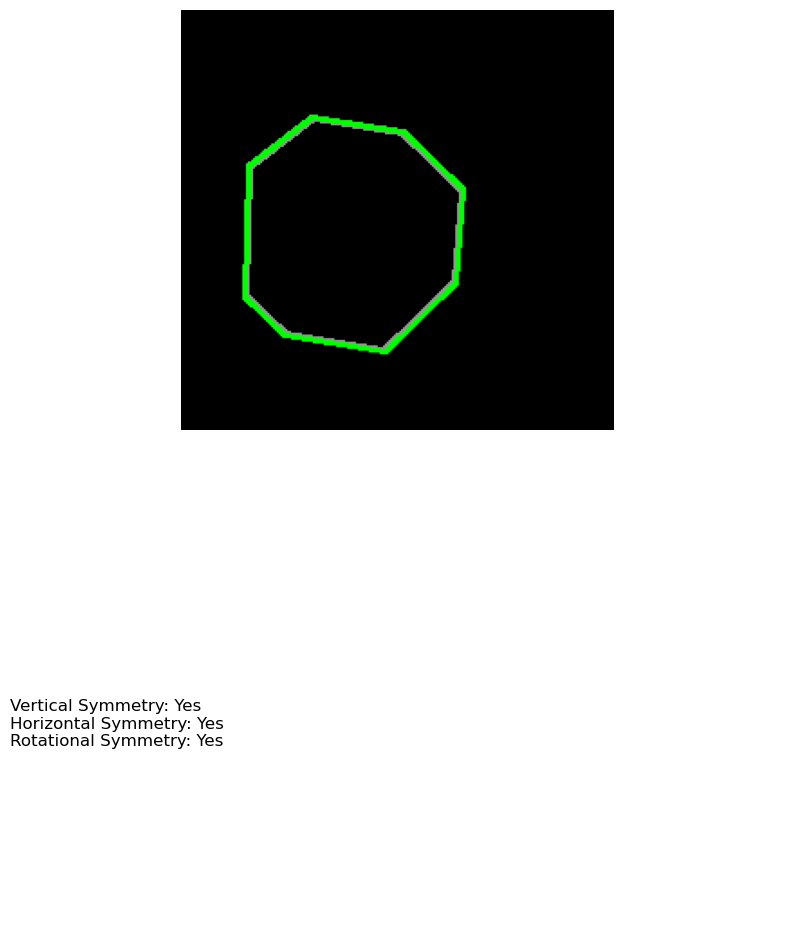

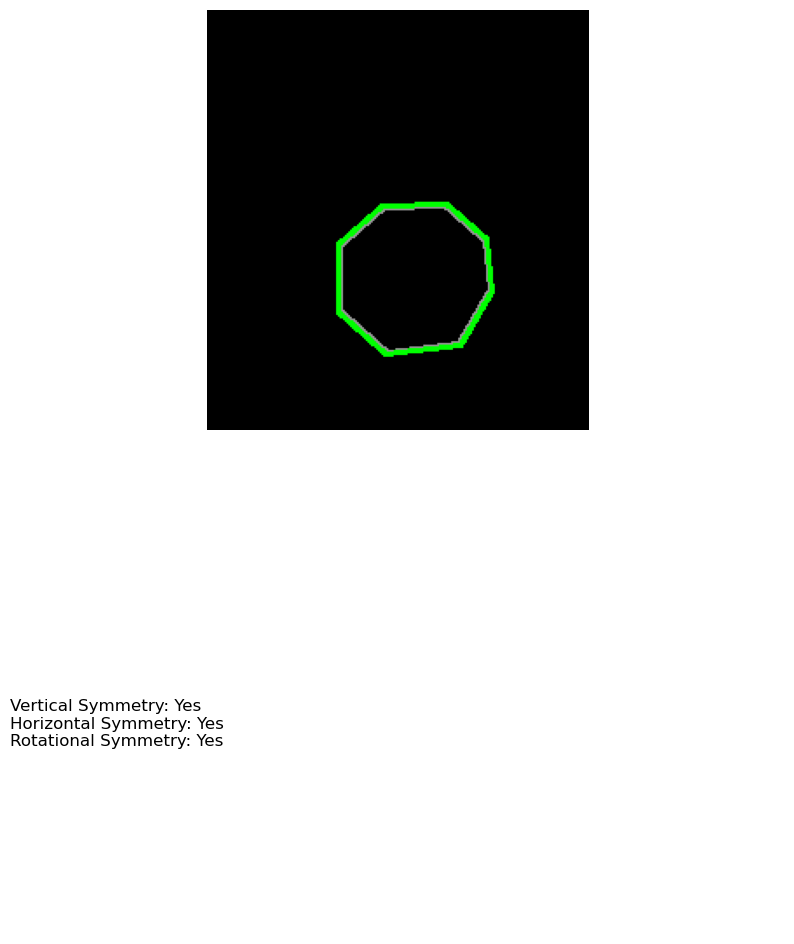

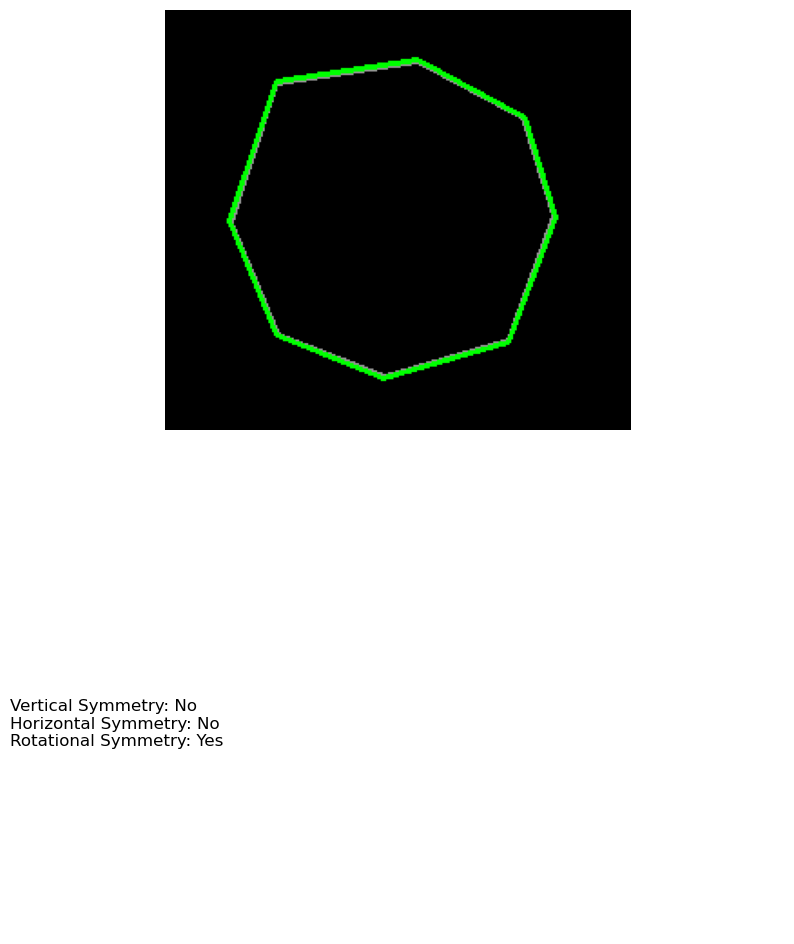

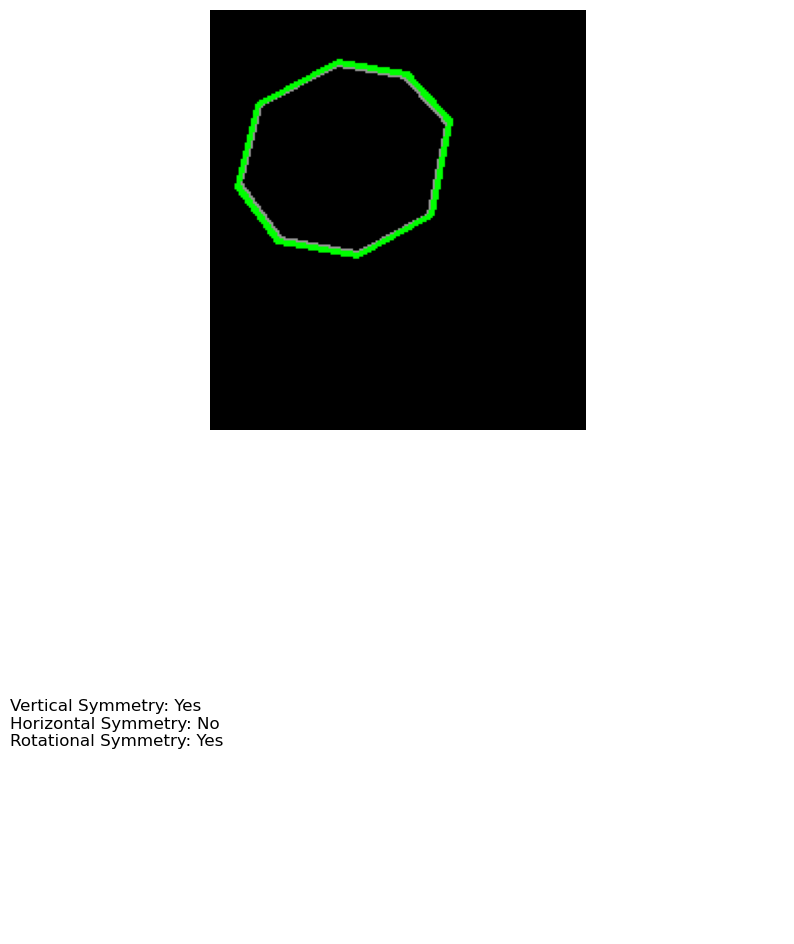

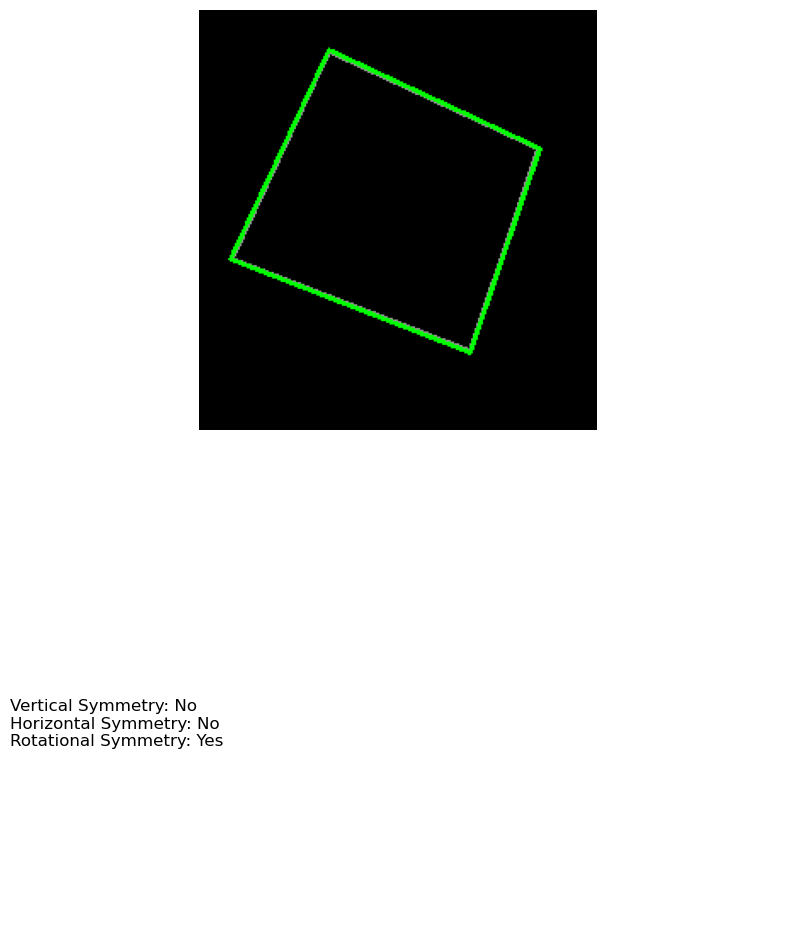

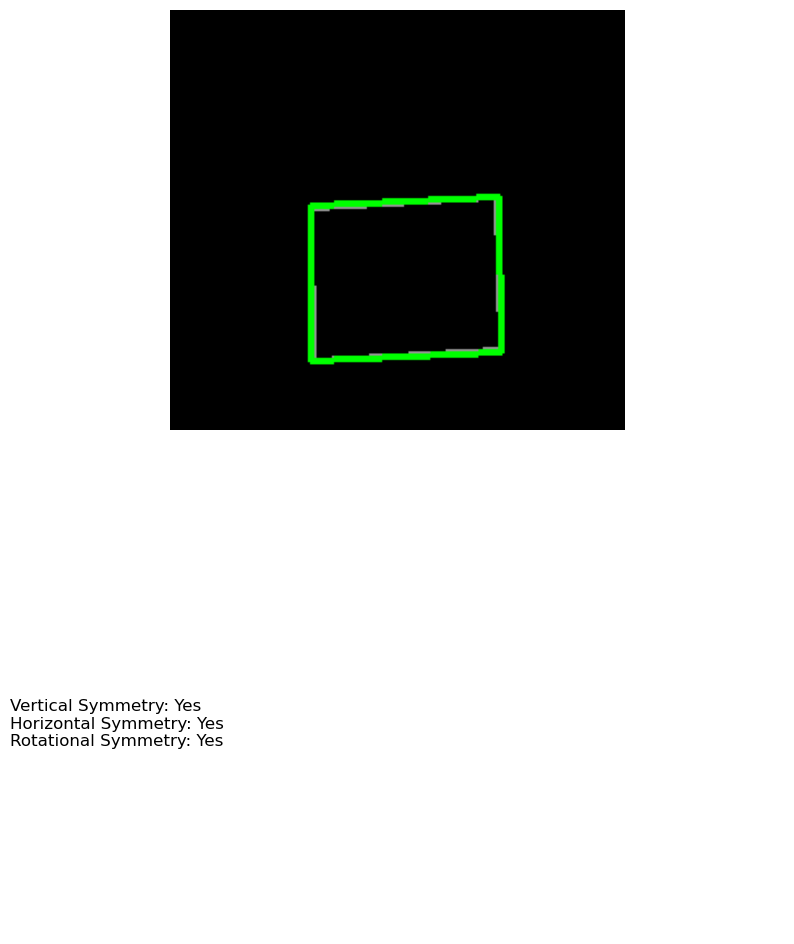

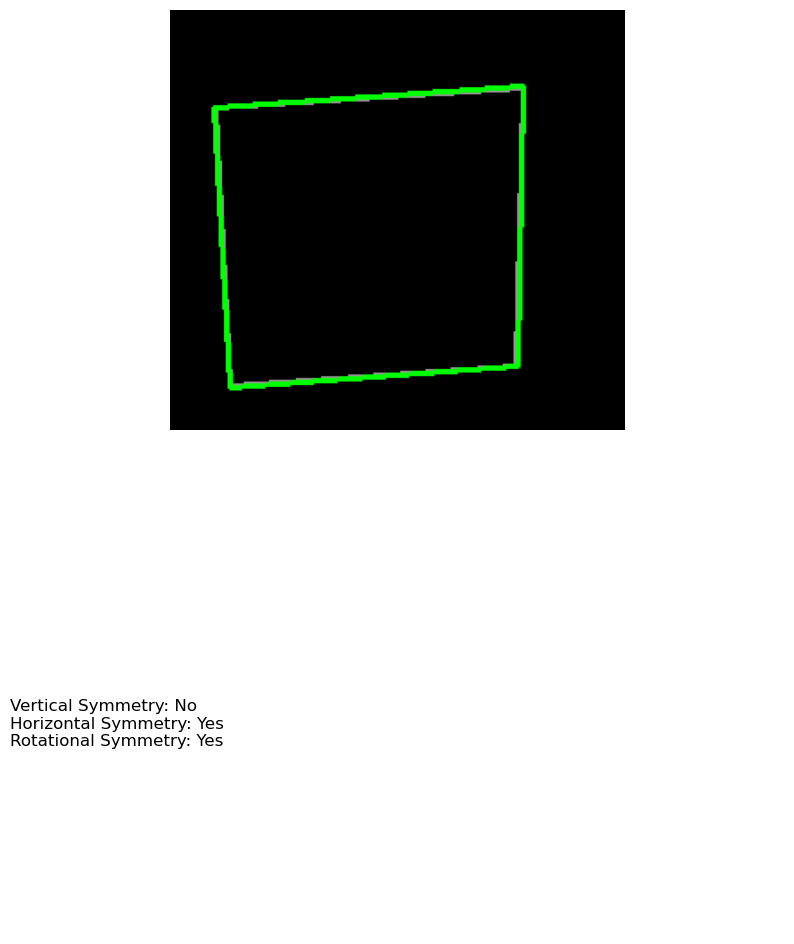

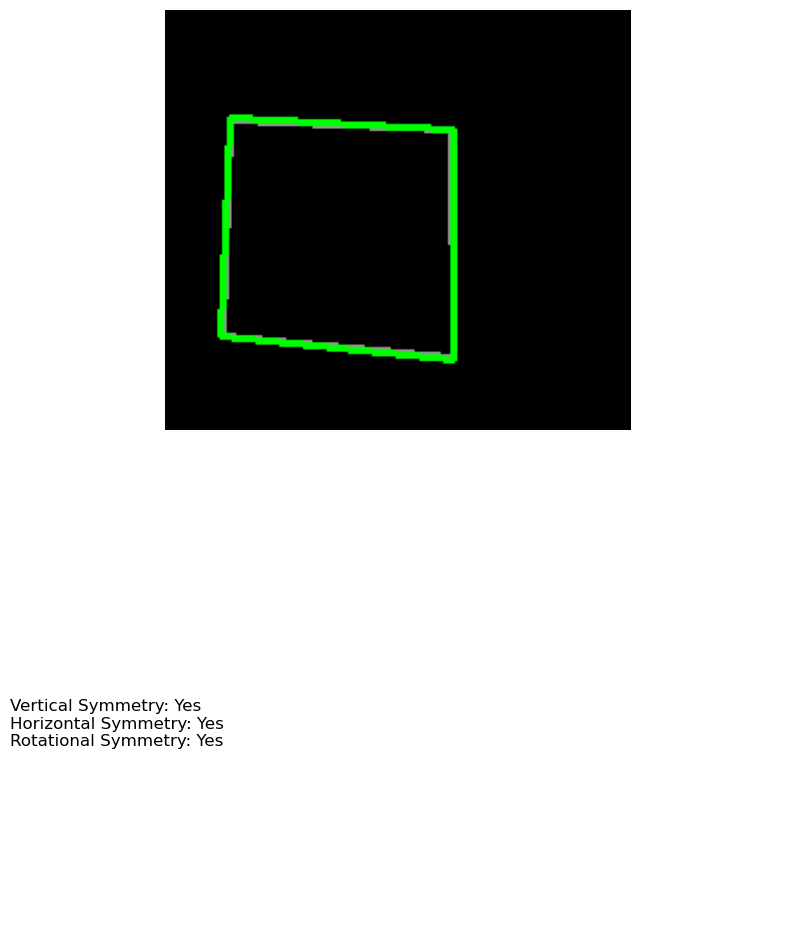

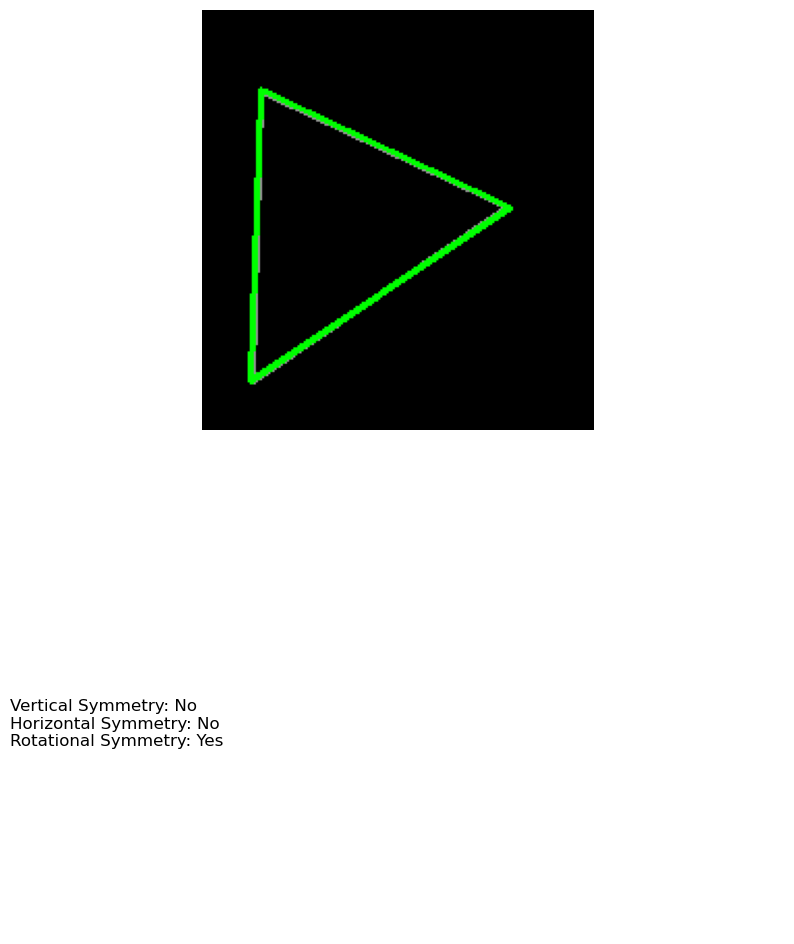

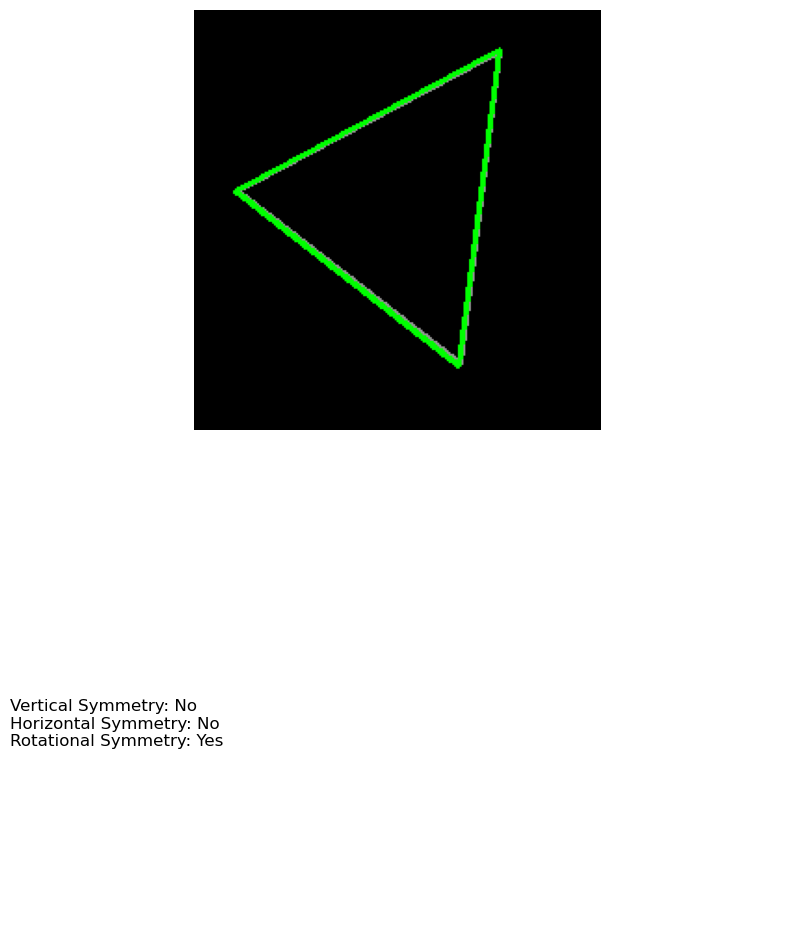

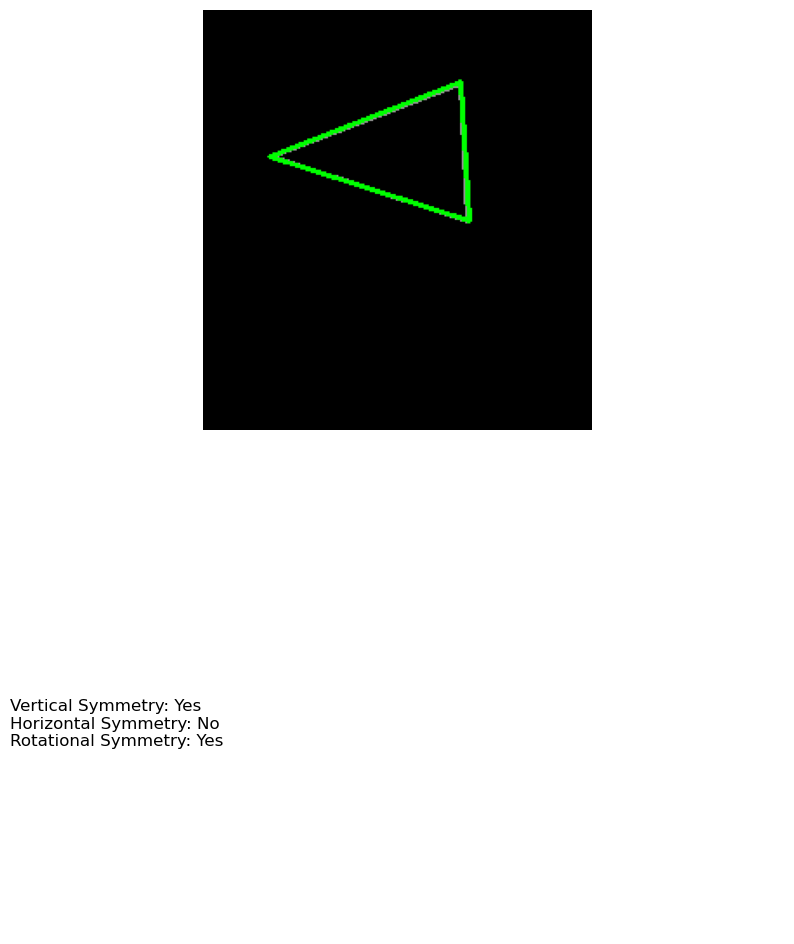

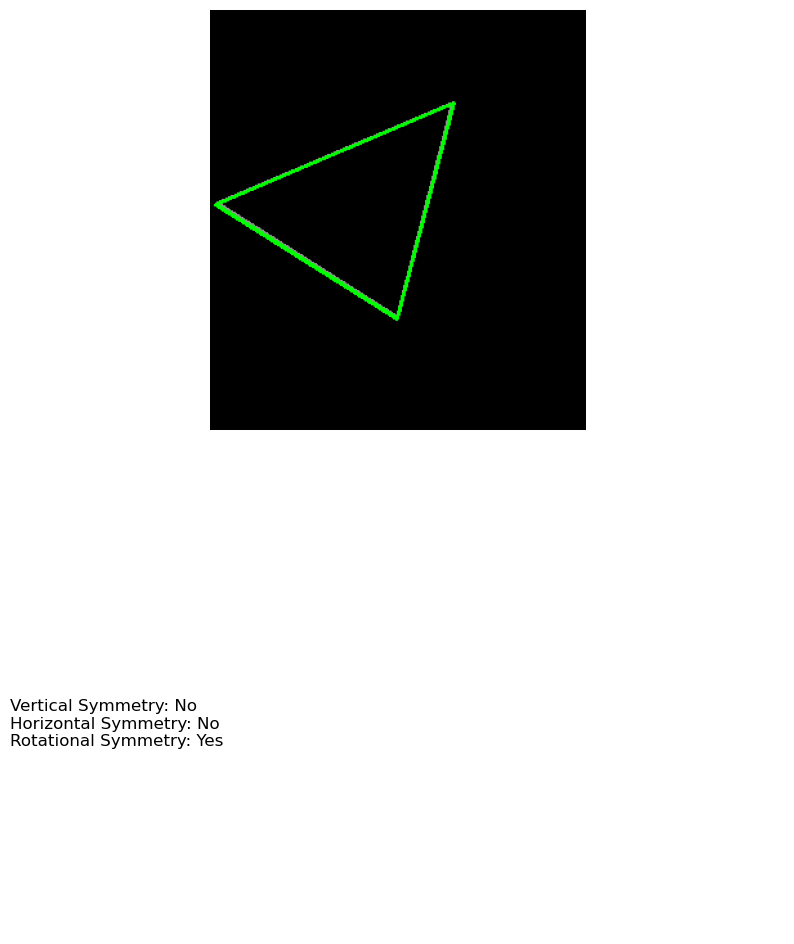

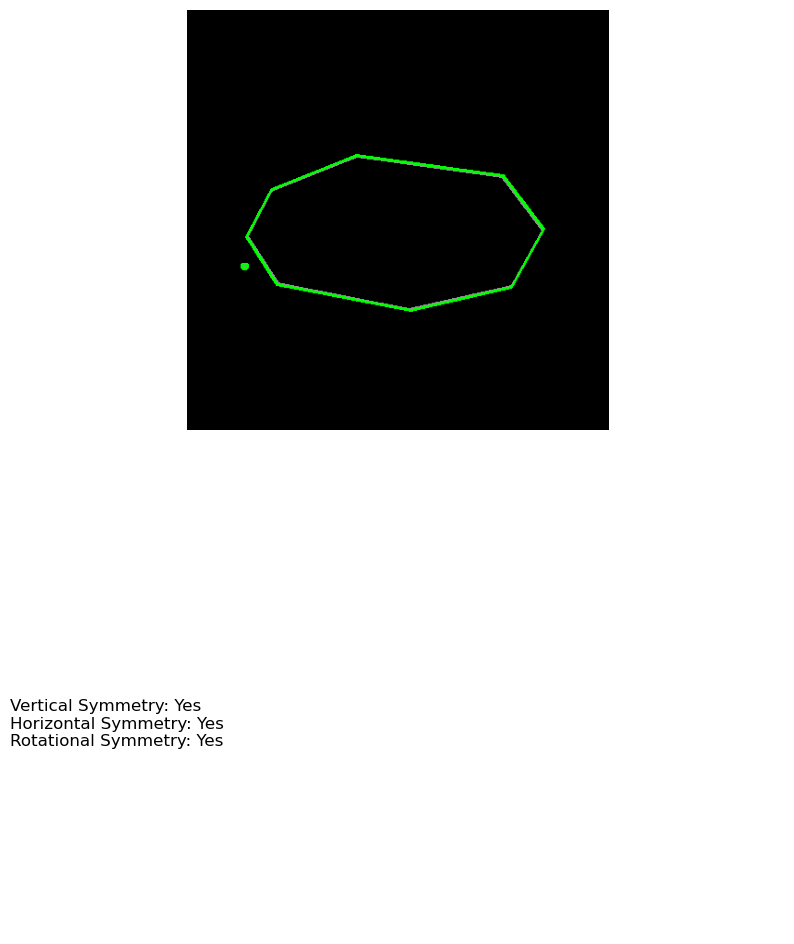

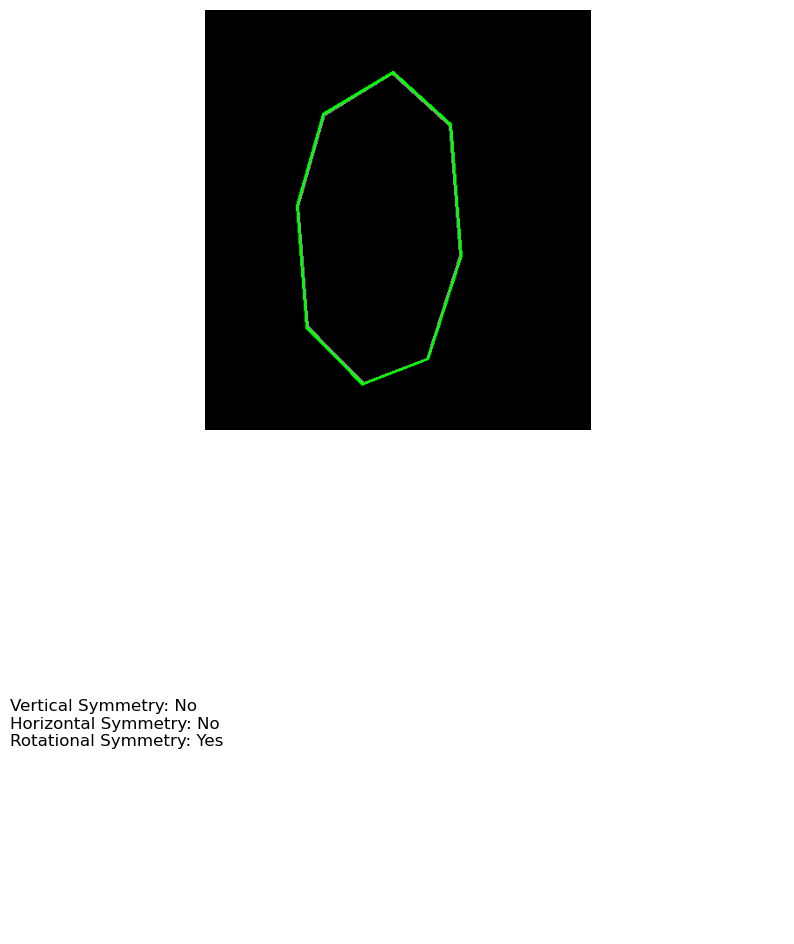

Image: polylines_Screenshot_2024-08-10-13-22-05-825_com.miui.gallery.png
Detected Symmetries: {'Vertical Symmetry': True, 'Horizontal Symmetry': True, 'Rotational Symmetry': True}

Image: polylines_Screenshot_2024-08-10-13-22-17-298_com.miui.gallery.png
Detected Symmetries: {'Vertical Symmetry': True, 'Horizontal Symmetry': True, 'Rotational Symmetry': True}

Image: polylines_Screenshot_2024-08-10-13-22-24-766_com.miui.gallery.png
Detected Symmetries: {'Vertical Symmetry': False, 'Horizontal Symmetry': False, 'Rotational Symmetry': True}

Image: polylines_Screenshot_2024-08-10-13-22-35-860_com.miui.gallery.png
Detected Symmetries: {'Vertical Symmetry': True, 'Horizontal Symmetry': False, 'Rotational Symmetry': True}

Image: polylines_Screenshot_2024-08-10-13-22-44-071_com.miui.gallery.png
Detected Symmetries: {'Vertical Symmetry': False, 'Horizontal Symmetry': False, 'Rotational Symmetry': True}

Image: polylines_Screenshot_2024-08-10-13-22-52-526_com.miui.gallery.png
Detected Symmetri

In [21]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

def vectorize_image(image_path):
    """Vectorize the given PNG image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    vectorized_contours = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vectorized_contours.append(approx)
    
    return vectorized_contours, image

def draw_vectorized_contours(image, vectorized_contours, symmetry_results):
    """Draw vectorized contours on the image and display it with symmetry results."""
    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color image for visualization
    
    for contour in vectorized_contours:
        if len(contour) > 0:
            cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)

    # Create a figure with two subplots: one for the image and one for symmetry results
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot the image with contours
    axs[0].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    
    # Plot the symmetry results
    axs[1].text(0, 0.5, '\n'.join([f"{key}: {'Yes' if value else 'No'}" for key, value in symmetry_results.items()]),
                fontsize=12, ha='left', va='center')
    axs[1].axis('off')
    
    plt.show()

def is_vertical_symmetric(contour):
    """Check if the shape has vertical symmetry."""
    if len(contour) == 0:
        return False

    x, y, w, h = cv2.boundingRect(contour)
    
    left_half = []
    right_half = []

    for point in contour:
        if point[0][0] < x + w / 2:
            left_half.append(point)
        else:
            right_half.append(point)
    
    left_half = np.array(left_half)
    right_half = np.array(right_half)
    
    reflected_right_half = np.array([[2 * (x + w / 2) - px, py] for px, py in right_half[:, 0]])
    
    left_half_mean = np.mean(left_half, axis=0)
    reflected_right_half_mean = np.mean(reflected_right_half, axis=0)
    
    distance = np.linalg.norm(left_half_mean - reflected_right_half_mean)
    
    return distance < 10  # Threshold for similarity

def is_horizontal_symmetric(contour):
    """Check if the shape has horizontal symmetry."""
    if len(contour) == 0:
        return False

    x, y, w, h = cv2.boundingRect(contour)
    
    top_half = []
    bottom_half = []

    for point in contour:
        if point[0][1] < y + h / 2:
            top_half.append(point)
        else:
            bottom_half.append(point)
    
    top_half = np.array(top_half)
    bottom_half = np.array(bottom_half)
    
    reflected_bottom_half = np.array([[px, 2 * (y + h / 2) - py] for px, py in bottom_half[:, 0]])
    
    top_half_mean = np.mean(top_half, axis=0)
    reflected_bottom_half_mean = np.mean(reflected_bottom_half, axis=0)
    
    distance = np.linalg.norm(top_half_mean - reflected_bottom_half_mean)
    
    return distance < 10  # Threshold for similarity
    
def is_rotationally_symmetric(contour, angle=180):
    """Check if the shape has rotational symmetry."""
    if len(contour) == 0:
        return False
    
    # Flatten the contour to ensure correct shape
    contour = contour.reshape(-1, 1, 2).astype(np.float32)
    
    center = np.mean(contour, axis=0)[0]
    rotation_matrix = cv2.getRotationMatrix2D(tuple(center), angle, 1.0)
    rotated_contour = cv2.transform(contour, rotation_matrix)
    
    # Flatten the rotated contour to compare
    rotated_contour = rotated_contour.reshape(-1, 2)
    contour_mean = np.mean(contour, axis=0)
    rotated_mean = np.mean(rotated_contour, axis=0)
    
    distance = np.linalg.norm(contour_mean - rotated_mean)
    
    return distance < 10  # Threshold for similarity

def detect_symmetry(vectorized_contours):
    """Detect symmetry types in the given vectorized contours."""
    results = {
        'Vertical Symmetry': False,
        'Horizontal Symmetry': False,
        'Rotational Symmetry': False
    }
    
    for contour in vectorized_contours:
        if len(contour) == 0:
            continue
        if is_vertical_symmetric(contour):
            results['Vertical Symmetry'] = True
        if is_horizontal_symmetric(contour):
            results['Horizontal Symmetry'] = True
        if is_rotationally_symmetric(contour, angle=180):
            results['Rotational Symmetry'] = True
    
    return results

def process_images_in_directory(directory_path):
    """Process each PNG image in the directory, vectorize it, and detect symmetries."""
    symmetry_results = {}
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.png'):
            image_path = os.path.join(directory_path, filename)
            
            # Vectorize the image
            vectorized_contours, image = vectorize_image(image_path)
            
            # Detect symmetries
            results = detect_symmetry(vectorized_contours)
            symmetry_results[filename] = results
            
            # Draw and display the vectorized contours with symmetry results
            draw_vectorized_contours(image, vectorized_contours, results)
    
    return symmetry_results

# Example usage
directory_path = 'F:\\Adobe-GenSolve\\Dataset\\Testing\\Polyline-Hand-Drawn-Shapes'
symmetry_results = process_images_in_directory(directory_path)

for image, result in symmetry_results.items():
    print(f"Image: {image}")
    print("Detected Symmetries:", result)
    print()
